# Self-Supervised Representation Learning of Wafer Maps

In this notebook, we train FastSiam with a ConvNeXt-V2-nano backbone on the full training data (in a self-supervised fashion, of course).

## Imports

In [1]:
import os
import warnings

import lightly
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import seaborn as sns
import timm
import torch
import torchvision
import torchvision.transforms as T
from lightly.data import LightlyDataset
from lightly.data.collate import MultiViewCollateFunction
from lightly.loss import NegativeCosineSimilarity
from lightly.models.modules import SimSiamPredictionHead, SimSiamProjectionHead
from lightly.transforms.rotation import RandomRotate
from lightly.utils.debug import plot_augmented_images, std_of_l2_normalized
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms.functional import InterpolationMode

# suppress dataloader warnings
warnings.filterwarnings("ignore", ".*does not have many workers.*")
# set global random seed
pl.seed_everything(0)

Global seed set to 0


0

## Data
### Dataset

We wrap a `LightlyDataset` around a custom torch Dataset for our model to use. Note: although this `WaferMapDataset` takes in labels `y`, these will ***not*** be used during training! Specifically, a custom collate function will grab just $X_i$ from `train_dataset` and return augmentations of the sample (4 augmentations in our case).

In [2]:
class WaferMapDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.data = pd.concat([X, y], axis="columns")
        # All resizing is done in augmentations, so we have tensors/arraays of different sizes
        # Because of this, just create a list of tensors
        self.X_list = [torch.tensor(ndarray) for ndarray in X]
        self.y_list = [torch.tensor(ndarray) for ndarray in y]
        self.transform = transform

    def __getitem__(self, index):
        x = self.X_list[index]
        y = self.y_list[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.X_list)


train_data = pd.read_pickle("../data/cleaned_splits/train_data.pkl")

train_dataset = LightlyDataset.from_torch_dataset(
    WaferMapDataset(X=train_data.waferMap, y=train_data.failureCode)
)

### Image Augmentations and Collate Functions

Below, we create a callable class implementing our random die noise augmentation. We use the `flip` function from our data cleaning notebook. This is the only custom augmentation we'll be using here. All others come from torchvision (except for `RandomRotate`, which is just a custom augmentation from lightly that has a probability of rotating by exactly 90 degrees).

In [3]:
class DieNoise:
    def __call__(self, sample: torch.Tensor) -> torch.Tensor:
        def flip(item, p=0.03):
            """
            Given a wafermap die, flips pass to fail and vice-versa with probability p.
            Does nothing to non-die area (0's if 128's and 255's are passes/fails respectively).
            """
            prob = np.random.choice([False, True], p=[1 - p, p])
            if prob:
                if item == 128:
                    return 255
                elif item == 255:
                    return 128
                else:
                    return item
            return item

        vflip = np.vectorize(flip)
        out = vflip(sample)
        return torch.from_numpy(out)

We compose all our augmentations and create a collate function `FastSiamCollateFunction` for our model below, using `plot_augmented_images` to verify that this will work on the data we've loaded in our `train_dataset` earlier.

<Figure size 640x480 with 0 Axes>

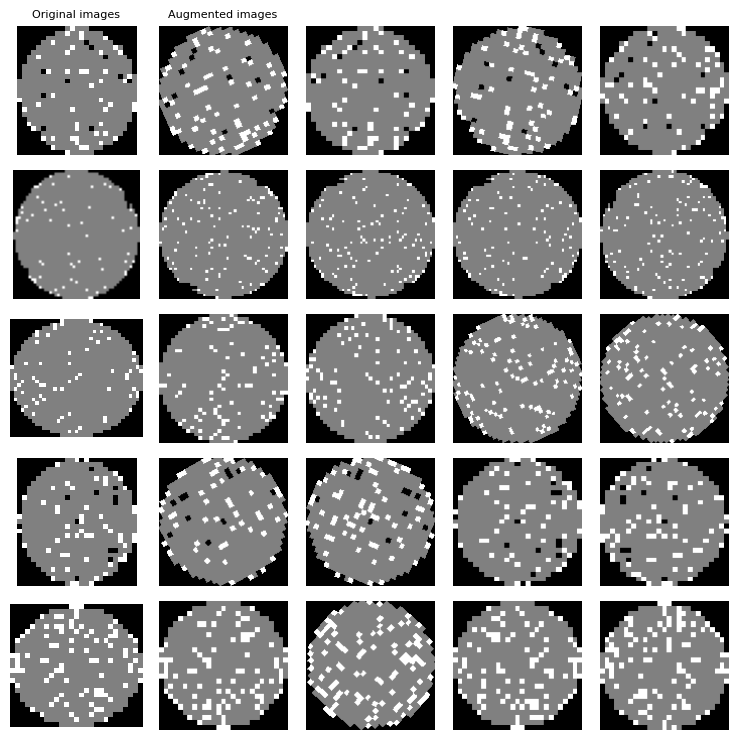

In [4]:
transforms = T.Compose([
    # Add die noise before anything else
    DieNoise(),
    # Convert to PIL Image, then perform all torchvision transforms
    T.ToPILImage(),
    T.Resize([128, 128], interpolation=InterpolationMode.NEAREST),
    RandomRotate(),
    T.RandomVerticalFlip(),
    T.RandomHorizontalFlip(),
    T.RandomApply(
        torch.nn.ModuleList(
            [T.RandomRotation(90, interpolation=InterpolationMode.NEAREST)]
        ),
        0.25,
    ),
    # Finally, create a 3-channel image since we use ResNet, and convert to tensor
    T.Grayscale(num_output_channels=3),  # R == G == B
    T.ToTensor(),
])

# Collate function will grab an image and return 4 augmentations based on transforms above
FastSiamCollateFunction = MultiViewCollateFunction([transforms] * 4)

plt.set_cmap("gray")
plot_augmented_images(
    # Grab 5 random samples from X_train to visualize original and augmented images for each
    train_data.waferMap.iloc[np.random.choice(len(train_data), 5)].tolist(),
    FastSiamCollateFunction,
);

## Training FastSiam

With a batch size of 64 on a 3080 Ti (12 GB of VRAM), training for 10 epochs takes around 14 hours.

In [5]:
class FastSiam(pl.LightningModule):
    def __init__(self):
        super().__init__()
        # create a ConvNeXt model without the fc layer head
        # self.backbone = timm.create_model("convnext_nano", num_classes=0)
        self.backbone = timm.create_model("convnextv2_nano", num_classes=0)
        # Original paper uses dimension d=2048. We use 1024 here for lower complexity.
        self.projection_head = SimSiamProjectionHead(640, 1024, 1024)
        # prediction MLP’s hidden layer dimension is always 1/4 of the output dimension
        self.prediction_head = SimSiamPredictionHead(1024, 256, 1024)
        self.criterion = NegativeCosineSimilarity()

    def forward(self, x):
        f = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(f)
        p = self.prediction_head(z)
        z = z.detach()
        return z, p

    def training_step(self, batch, batch_idx):
        # Unpack augmented views
        views, _, _ = batch
        x1, x2, x3, x4 = views

        # Pass each view through projector to get z, and predictor to get p
        z1, p1 = self.forward(x1)
        z2, p2 = self.forward(x2)
        z3, p3 = self.forward(x3)
        z4, p4 = self.forward(x4)

        # Use mean of the last N - 1 projected views
        mean = (z2 + z3 + z4) / 3

        # Compute loss using prediction of 1st view, mean of remaining projected views
        loss = self.criterion(p1, mean)

        # Keep a log of the loss
        self.log("loss", loss)
        # Monitor the STD of L2-normalized representation to check if it collapses (bad)
        self.log("z1 std", std_of_l2_normalized(z1))
        self.log("z2 std", std_of_l2_normalized(z2))
        self.log("z3 std", std_of_l2_normalized(z3))
        self.log("z4 std", std_of_l2_normalized(z4))

        self.log("mean std", std_of_l2_normalized(mean))

        self.log("p1 std", std_of_l2_normalized(p1))
        self.log("p2 std", std_of_l2_normalized(p2))
        self.log("p3 std", std_of_l2_normalized(p3))
        self.log("p4 std", std_of_l2_normalized(p4))

        return loss

    def configure_optimizers(self):
        # FastSiam authors use lr=0.125 (?!), SimSiam would use 0.00625 here. 0.06 is a happy medium :)
        optim = torch.optim.SGD(self.parameters(), lr=0.06)
        return optim

model = FastSiam()
train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    collate_fn=FastSiamCollateFunction,
    drop_last=True
)

accelerator = "gpu" if torch.cuda.is_available() else "cpu"

trainer = pl.Trainer(max_epochs=10, accelerator=accelerator, devices=-1)
trainer.fit(model=model, train_dataloaders=train_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                     | Params
-------------------------------------------------------------
0 | backbone        | ConvNeXt                 | 15.0 M
1 | projection_head | SimSiamProjectionHead    | 2.8 M 
2 | prediction_head | SimSiamPredictionHead    | 525 K 
3 | criterion       | NegativeCosineSimilarity | 0     
-------------------------------------------------------------
18.3 M    Trainable params
0         Non-trainable params
18.3 M    Total params
73.061    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
